In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torchmetrics import MetricCollection, classification, wrappers

In [2]:
from Modules import Fingerprint_Generator

fingerprint = "ecfp-count"

# df = pd.read_csv("Transformed_Data/DILIst_DILI.csv", index_col=0)  # Map style dataset
# df = Fingerprint_Generator.generate_fp_column(df, df.drug, fp_type=fingerprint)

# df_fp = pd.DataFrame(df.iloc[:, 2])
# df_fp.insert(len(df_fp.columns), "DILI?", df.iloc[:, 1].astype(int))  # Insert 'DILI?' column as the last column

# df_fp.to_csv("Transformed_Data/testo")

In [3]:
df = pd.read_csv('Transformed_Data/rega_train.csv')
df = Fingerprint_Generator.generate_fp_column(df, df.smiles, fp_type=fingerprint)
df = df.drop("smiles", axis=1)
print(df.head(2))

   label                                         ecfp-count
0      0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1      0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [4]:
class DILIDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels) -> None:
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        features = self.features.iloc[index]
        labels = self.labels.iloc[index]
        return torch.tensor([features], dtype=torch.float32), torch.tensor([labels], dtype=torch.float32)
        # return torch.from_numpy(np.asarray([features])), torch.from_numpy(np.asarray([labels]))


# DILIfeatures = df_fp.iloc[:, 0]
# DILIlabels = df_fp.iloc[:, 1]

DILIfeatures = df.iloc[:, 1]
DILIlabels = df.iloc[:, 0]

dilidataset = DILIDataset(DILIfeatures, DILIlabels)

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
torch.manual_seed(42)

BATCH_SIZE = 64

train_size = int(len(dilidataset) * 0.8)
validation_size = len(dilidataset) - train_size

train_data, validation_data = torch.utils.data.random_split(dilidataset, [train_size, validation_size])

if len(train_data) + len(validation_data) == len(dilidataset):
    print("Dataset split succeeded")
else:
    print("Dataset split failed")

Dataset split succeeded


In [7]:
# Set the device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

Using cuda device: NVIDIA GeForce GTX 1070


In [8]:
# from My_Pytorch_Utilities import reset_weights

def reset_weights(model, verbose: bool = False) -> None:
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
            if verbose is False:
                pass
            else:
                print(f"Reset trainable parameters of layer = {layer}")


class DILI_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        model_output = self.fc1(x)
        model_output = torch.relu(model_output)
        model_output = self.fc2(model_output)
        model_output = torch.relu(model_output)
        model_output = self.fc3(model_output)
        model_output = self.sigmoid(model_output)
        return model_output


class DILI_Predictor_Sequential(nn.Sequential):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

model0 = DILI_Predictor_Sequential(2048, 512, 1).to(device)

# model0 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

In [9]:
metric_collection = MetricCollection([
    classification.Accuracy(task='binary', average='macro').to(device),
    classification.BinaryAUROC().to(device),
    classification.BinaryMatthewsCorrCoef().to(device)
    ])

b_acc = classification.Accuracy(task='binary', average='macro').to(device)


In [10]:
from Modules import Fingerprint_Comparator

df = pd.read_csv('Transformed_Data/rega_train.csv')

print(df)

Fingerprint_Comparator.Pytorch_Train(df.iloc[:,0], df.iloc[:,1], model0, 2048, metric_collection).regular_fingerprint(["ecfp", "ecfp-count"])

                                                 smiles  label
0                                     CN(C)C(=N)N=C(N)N      0
1                                      COC(=O)C=CC(=O)O      0
2                                     O=C(O)C=Cc1ccccc1      0
3                                     Cc1ccc(C(C)C)cc1O      0
4                                    COc1ccc(C(=O)O)cc1      0
...                                                 ...    ...
2339  COc1ccc(CCOC2OC(CO)C(OC(=O)C=Cc3ccc(O)c(OC)c3)...      0
2340  COc1ccc(-c2oc3c(CC=C(C)C)c(OC4OC(CO)C(O)C(O)C4...      0
2341  COC(=O)C12Oc3cc(C)c(-c4c(C)cc5c(c4O)C(O)=C4C(=...      0
2342  CC1(C)CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CC(O)C(OC...      0
2343                       Oc1ccc(C=Cc2cc(O)cc(O)c2)cc1      0

[2344 rows x 2 columns]


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
  0%|          | 0/2 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'iloc'

In [15]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_metrics = metric_collection.clone(prefix="train_")
    train_loss, train_accuracy = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        predicted_y = model0(X)
        predicted_y = predicted_y.squeeze(1)

        loss = loss_fn(predicted_y, y)
        train_loss += loss.item()
        train_metrics_results = train_metrics(predicted_y, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_metrics_results = train_metrics.compute()
    train_metrics.reset()
    
    train_loss = train_loss / len(dataloader)

    return train_loss, train_metrics_results #, predicted_y, y

In [16]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()
    test_metrics = metric_collection.clone(prefix="test_")
    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_predicted_y = model0(X)
            test_predicted_y = test_predicted_y.squeeze(1)
            # print(test_predicted_y.shape); print(y.shape)#  Uncomment to confirm shape

            loss = loss_fn(test_predicted_y, y)
            test_loss += loss.item()
            
            test_metrics_results = test_metrics(test_predicted_y, y)
        
        test_metrics_results = test_metrics.compute()
        test_metrics.reset()

    test_loss = test_loss / len(dataloader)
    
    return test_loss, test_metrics_results

In [12]:
def metics_tensor_dict_to_floats(metrics):
    return {key: value.to(device='cpu', non_blocking=True).item() if hasattr(value, 'to') 
else value for key, value in metrics.items()}

In [17]:
from sklearn.model_selection import StratifiedKFold


def train(model: torch.nn.Module, dataset: torch.utils.data.Dataset, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.BCELoss(), epochs: int = 10, k_folds: int = 5, batch_size: int = 256, DP:int = 3):
    kfold = StratifiedKFold(k_folds, shuffle=True, random_state=42)
    score_df = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset, dataset.labels)): 
        loss = {"train_loss": [], "test_loss": []}
        
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)
        
        reset_weights(model)

        for epoch in range(epochs):
            # tracker.increment()
            train_loss, train_metrics = train_step(model=model, dataloader=train_loader, loss_fn=loss_fn, optimizer=optimizer)
            # tracker.update(predicted_y, y)
            test_loss, test_metrics = test_step(model=model, dataloader=test_loader, loss_fn=loss_fn)

            train_metrics, test_metrics = metics_tensor_dict_to_floats(train_metrics), metics_tensor_dict_to_floats(test_metrics)
            loss["train_loss"].append(train_loss)
            loss["test_loss"].append(test_loss)
            
            if EarlyStopper().early_stop(test_loss):
                break

        score_df.append(pd.DataFrame.from_dict(test_metrics, orient="index").transpose().round(DP))
        
        print(f"Fold {fold+1} final results after {epoch+1} epochs: Train Acc: {train_metrics['train_BinaryAccuracy']:.{DP}f} Train Loss: {train_loss:.{DP}f} (n = {len(train_idx)}) | Test Acc: {test_metrics['test_BinaryAccuracy']:.{DP}f} Test Loss: {test_loss:.{DP}f} (n = {len(test_idx)}) ")

    score_df = pd.concat(score_df)
    score_df.insert(0, "Fold", range(k_folds))
    score_df.set_index("Fold", inplace=True)
    
    return loss, score_df #, tracker.compute_all()

In [14]:
# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=1e-4)

reset_weights(model0)
model0_loss, model0_df = train(model=model0, dataset=dilidataset, optimizer=optimizer, loss_fn=loss_fn, epochs=1, k_folds=2, batch_size=256)

NameError: name 'train' is not defined

In [18]:
from Modules import PyTorch_Training

PyTorch_Training.Model_Train_Test(model0, metric_collection, loss_fn=loss_fn).train_model(dilidataset, epochs=2)

Results after 1 epochs: Train Acc: 0.000 Train Loss: 0.690 (n = 1875) | Test Acc: 0.000 Test Loss: 0.685 (n = 469) 
Results after 2 epochs: Train Acc: 0.571 Train Loss: 0.675 (n = 1875) | Test Acc: 0.671 Test Loss: 0.676 (n = 469) 


({'train_loss': [0.6896825283765793, 0.6748193502426147],
  'test_loss': [0.6847695708274841, 0.675948828458786]},
        test_BinaryAccuracy  test_BinaryAUROC  test_BinaryMatthewsCorrCoef
 Epoch                                                                    
 0                    0.000             0.000                        0.000
 1                    0.671             0.725                        0.616)

In [ ]:
regular_fingerprints = [
    "ecfp",
    "ecfp-count",
    "fcfp"
]
df = pd.read_csv('Transformed_Data/rega_train.csv')

fp_df = []



for fingerprint in regular_fingerprints:
    df = pd.read_csv('Transformed_Data/rega_train.csv')
    df = Fingerprint_Generator.generate_fp_column(df, df.smiles, fp_type=fingerprint)
    df = df.drop("smiles", axis=1)
    
    DILIfeatures = df.iloc[:, 1]
    DILIlabels = df.iloc[:, 0]
    
    dilidataset = DILIDataset(DILIfeatures, DILIlabels)
    
    
    loss, score_df = train(model=model0, dataset=dilidataset, optimizer=optimizer, loss_fn=loss_fn, epochs=10, k_folds=5, batch_size=256)
    
    fp_df.append(score_df)

c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Fold 1 final results after 10 epochs: Train Acc: 0.389 Train Loss: 0.494 (n = 1875) | Test Acc: 0.877 Test Loss: 0.575 (n = 469) 
Fold 2 final results after 10 epochs: Train Acc: 0.377 Train Loss: 0.491 (n = 1875) | Test Acc: 0.875 Test Loss: 0.579 (n = 469) 


KeyboardInterrupt: 

In [ ]:
# print(fp_df)

from scipy.stats import wilcoxon, friedmanchisquare

# print(fp_df[0].iloc[:, 1]); print(fp_df[1].iloc[:, 1])

friedmanchisquare(fp_df[0].iloc[:, 1], fp_df[1].iloc[:, 1], fp_df[2].iloc[:, 1])

FriedmanchisquareResult(statistic=2.8000000000000043, pvalue=0.24659696394160596)

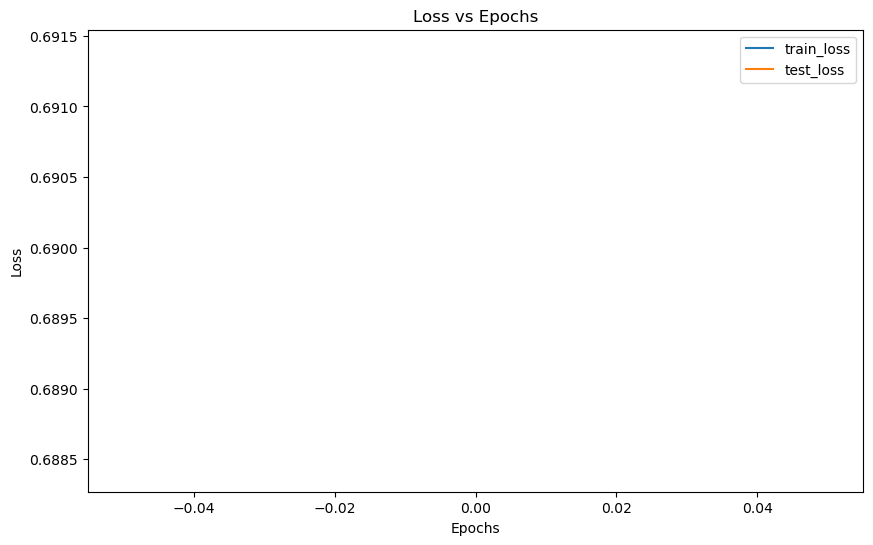

In [ ]:
import matplotlib.pyplot as plt


def plot_loss_curve(results: dict[str, list[float]]):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Plot loss
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    
    plt.title("Loss vs Epochs")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curve(model0_loss)

In [ ]:
# from Modules import My_Pytorch_Utilities

# dummy_data = torch.rand([1, 2048])

# dummy_data.shape

# My_Pytorch_Utilities.save(model0, "DILIst", dummy_data.to(device))

In [ ]:
from Modules import PyTorch_Pretrained_Inference

validation_smiles = ["CCC", "CCCC", "Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C"]
validation_smiles_labels = [1, 0, 1]

regular_fingerprints = [
    "ecfp",
    "fcfp",
    "secfp",
]

PyTorch_Pretrained_Inference.DILI_Inference(validation_smiles, model0).regular_fingerprint(regular_fingerprints)

TypeError: Fingerprint_Comparator.__init__() missing 1 required positional argument: 'labels'

In [ ]:
from Modules import Fingerprint_Comparator

Fingerprint_Comparator.PyTorch_Pretrained(validation_smiles, validation_smiles_labels, model0).regular_fingerprint(regular_fingerprints, 2048)

100%|██████████| 3/3 [00:00<00:00, 272.64it/s]


,Fingerprint type,acc
0,ecfp,0.333333
1,fcfp,0.333333
2,secfp,0.333333


In [ ]:
# ## Assuming you have loaded_model and device available

# from Modules import Fingerprint_Generator

# validation_smiles = ["CCC", "CCCC", "Fc1ccc(cc1)[C@@]3(OCc2cc(C#N)ccc23)CCCN(C)C"]

# def evaluate_smiles(model, input_smiles):
#     scores = {}
#     validation_fp = Fingerprint_Generator.Smiles_To_Fingerprint(input_smiles, fingerprint).astype(torch.Tensor).squeeze(1).to(device)
#     with torch.no_grad():
#         model0.eval()
#         for i, input in enumerate(validation_fp):
#             output = model(input)
#             scores.update({round(output.item(), 3): validation_smiles[i]})
#             # scores.append(output.item())
#         return scores

# print(evaluate_smiles(model0, validation_smiles))


# # print(f"Prediction for {validation_smiles}: {prediction:.3f}")